## RUL prediction using Long Short Term Memory (LSTM) FD001

In this notebook, we will use LSTM to predict RUL of NASA's turbofan engine dataset FD001. We will show the implementation without going into the theory of LSTM.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(34)

In [ ]:
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.14.0
Numpy version:  1.23.5
Pandas version:  1.5.3
Scikit-learn version:  1.2.2


#### Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 125
* Window length: 30
* Shift: 1
* Data scaling: Standard scaling and Full dataset scaling.

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate.

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Cmaps.zip' -d /content/dataset



unzip:  cannot find or open /content/drive/MyDrive/Cmaps.zip, /content/drive/MyDrive/Cmaps.zip.zip or /content/drive/MyDrive/Cmaps.zip.ZIP.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

In [ ]:
print("Tensorflow Version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow Version:  2.14.0
Numpy version:  1.23.5
Pandas version:  1.5.3
Scikit-learn version:  1.2.2


In [ ]:
import os
import pandas as pd

# Prompt the user for the flight condition
flight_condition = input("Please enter the flight condition (1-4): ")

# Validate the user input
while flight_condition not in ['1', '2', '3', '4']:
    print("Invalid input. Please try again.")
    flight_condition = input("Please enter the flight condition (1-4): ")

# Set the file names based on the flight condition
train_file = f'train_FD00{flight_condition}.txt'
test_file = f'test_FD00{flight_condition}.txt'
rul_file = f'RUL_FD00{flight_condition}.txt'

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('/content/dataset/CMaps', train_file)
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('/content/dataset/CMaps', test_file)
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the RUL dataset as a dataframe
rul_dataset_path = os.path.join('/content/dataset/CMaps', rul_file)
true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



FileNotFoundError: ignored

In [ ]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function return last examples and number of last examples (a scaler) as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

There are two scaling strategies that we can employ. We can scale columnwise, ignoring individual engine based scaling. Or we can scale enginewise.

In [ ]:

window_length = 30
shift = 1
early_rul = 125
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

#### Training and validation split

We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [ ]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

#### LSTM model

In [ ]:
def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape = (window_length, 14), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences = True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", metrics="mae",optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

We will use a `Learning rate scheduler` callback that will change the learning rate after 5 epochs.

In [ ]:
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 128, verbose = 2)

Why did we run the model only for 10 epochs, even though the validation loss seems to be decreasing? Well, while training this model for more epochs, we previously observed that it is possible to decrease the validation loss to a very small number. But in that case, our actual test loss is not that great. This is because our model is overfitting the validation dataset. So to get a good test performance, we should stop our training at an intermediate value of the validation loss. We chose 10 epochs as that gives a good enough test error.

In [ ]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

In [ ]:
tf.keras.models.save_model(model, "FD001_LSTM_piecewise_RMSE_"+ str(np.round(RMSE, 4)) + ".h5")

We will now compute the RMSE by taking only last example of each engine.

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where,

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [ ]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

In [ ]:
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

# Results FD001

It is very likely that readers may get sligtly different results while running this notebook on their system. This happens because of the nondeterministic nature of some deep learning operations and dependence of libraries like `Tensorflow` on computer architecture. Therefore, to make our results reproducible, we also share saved models of all our notebooks. All saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/tree/master/saved_models/cmapss). A notebook describing the procedure to use the saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_using_saved_model_deep_learning.ipynb). As a final note remember that hyperparameter tuning is more of an art than science. It is possible to obtain better results than what has been obtained here by choosing better set of hyperparameters.

For other reproducible results on RUL, interested readers can visit my [project page](https://biswajitsahoo1111.github.io/rul_codes_open).

In [ ]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

#### Last 5 preds

In [ ]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

MAE = (mean_absolute_error(true_rul, mean_pred_for_each_engine))
print("MAE", MAE)

MAE_perc= mean_absolute_percentage_error(true_rul,mean_pred_for_each_engine)
print("MAE   " , MAE_perc)


s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

16/16 [==============================] - 0s 4ms/step
RMSE:  14.924283414675442
MAE 11.69177043247223
MAE    0.2015629544201476
S-score:  433.61579520912676


We will now compute the RMSE by taking only last example of each engine.

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)
MAE_new = mean_absolute_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " ,MAE_new)

MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " , MAE_perc)
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

RMSE (Taking only last examples):  15.109726898982043
% MAE only last examples   11.239905338287354
% MAE only last examples   0.1641893299713881
S-score:  420.54334755535365


In [ ]:
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.io import output_notebook

def plot_history(fit_history):
    output_notebook()  # Enable inline plotting in Jupyter notebooks
    metrics = ['loss', 'mae']
    titles = ['Loss', 'MAE']
    plots = []

    for i, metric in enumerate(metrics):
        p = figure(title=titles[i], x_axis_label='Epochs', y_axis_label=metric)
        p.line(fit_history.epoch, fit_history.history[metric], line_color='blue', legend_label='Train')
        if 'val_' + metric in fit_history.history:
            p.line(fit_history.epoch, fit_history.history['val_' + metric], line_color='red', legend_label='Validation')
        plots.append(p)

    grid = gridplot([[plots[0], plots[1]]], plot_width=400, plot_height=300)
    show(grid)

# Assuming 'history' is your fit history data
plot_history(history)


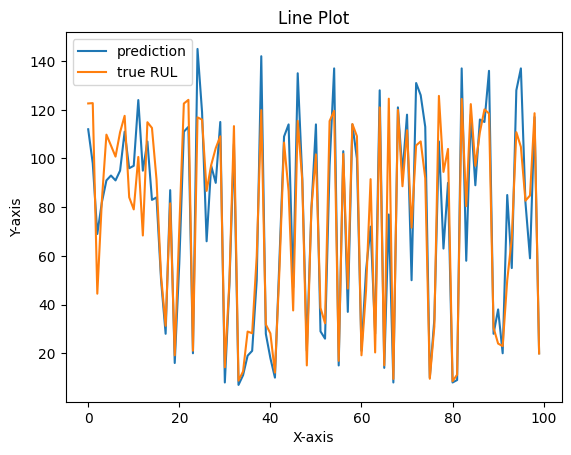

In [ ]:


def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
plot_series(true_rul, preds_for_last_example)

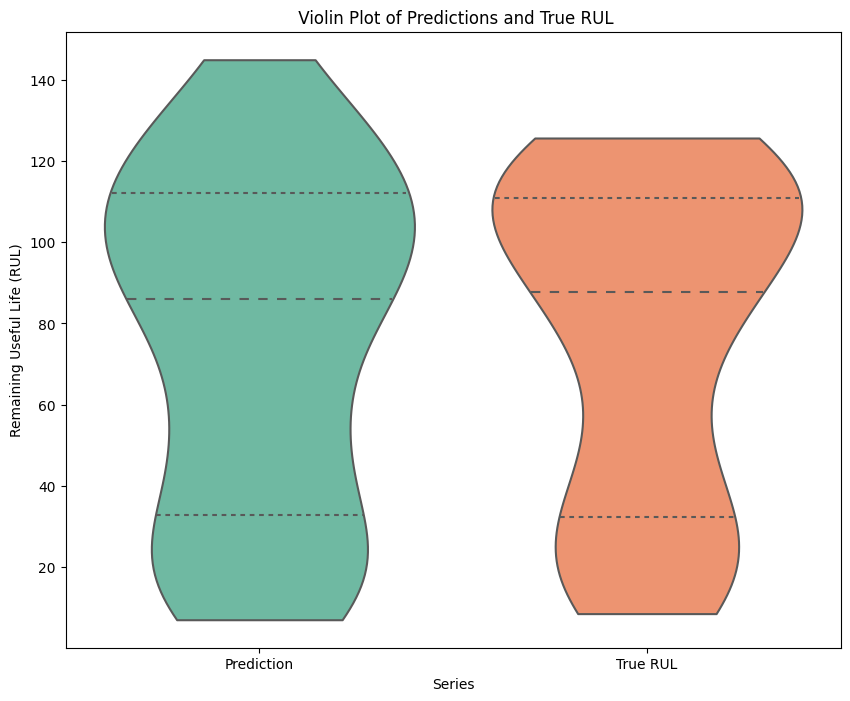

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                   cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8, trim=True,
                   range=(min_value, max_value))

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series(true_rul, preds_for_last_example)


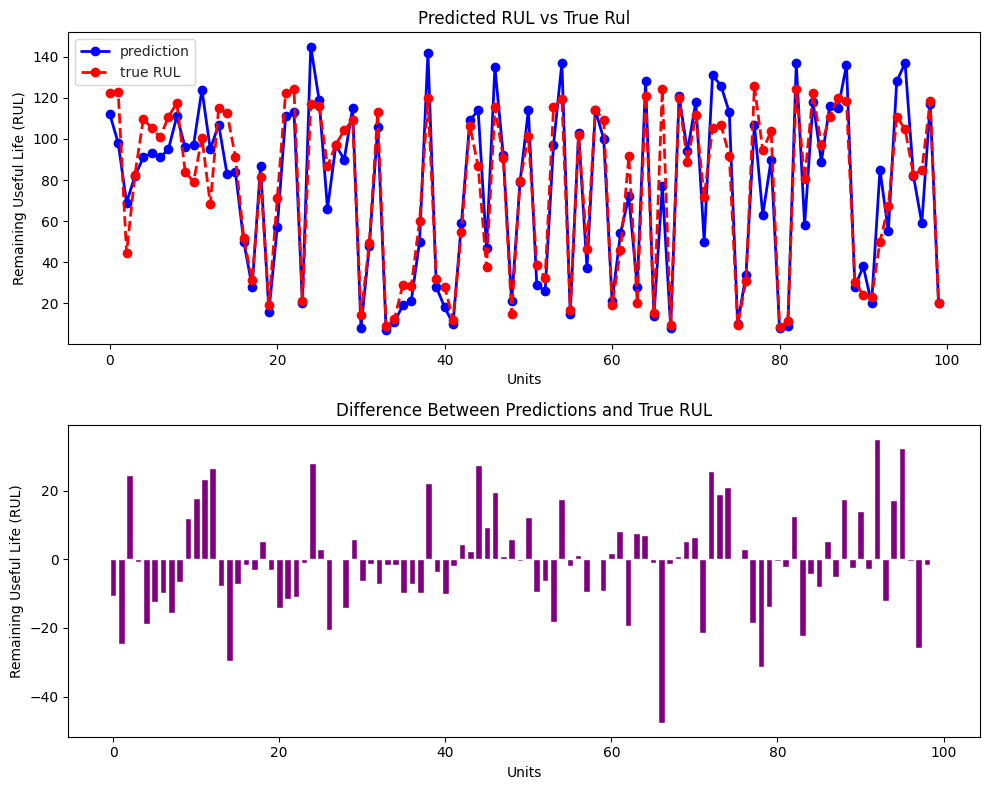

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series(true_rul, preds_for_last_example)


In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_critical_mae(predictions, true_rul):
    # Convert lists to numpy arrays for element-wise operations
    predictions = np.array(predictions)
    true_rul = np.array(true_rul)

    # Find the indices where true RUL is less than 15
    critical_indices = np.where(true_rul < 15)

    # Extract the critical predictions and true RUL
    critical_predictions = predictions[critical_indices]
    critical_true_rul = true_rul[critical_indices]

    # Calculate the MAE
    mae = mean_absolute_error(critical_true_rul, critical_predictions)

    return mae


In [ ]:
mae = evaluate_critical_mae(preds_for_last_example, true_rul)
print(f"The MAE for critical predictions is: {mae}")


The MAE for critical predictions is: 1.119092305501302


# RUL prediction using Long Short Term Memory (LSTM) FD002

In this notebook, we will use LSTM to predict RUL of NASA's turbofan engine dataset FD002. We will show the implementation without going into the theory of LSTM.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import pandas as pd
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

np.random.seed(323)

In [ ]:
print("Numpy version: ", np.__version__)
print(("Scikit-learn version: ", sklearn.__version__))
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Numpy version:  1.22.4
('Scikit-learn version: ', '1.2.2')
Pandas version:  1.5.3
Scikit-learn version:  1.2.2


#### Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 125
* Window length: 30
* Shift: 1
* Data scaling: No (Tree based methods don't require data scaling)

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate.

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly.

In [ ]:
import os
import pandas as pd

# Prompt the user for the flight condition
flight_condition = input("Please enter the flight condition (1-4): ")

# Validate the user input
while flight_condition not in ['1', '2', '3', '4']:
    print("Invalid input. Please try again.")
    flight_condition = input("Please enter the flight condition (1-4): ")

# Set the file names based on the flight condition
train_file = f'train_FD00{flight_condition}.txt'
test_file = f'test_FD00{flight_condition}.txt'
rul_file = f'RUL_FD00{flight_condition}.txt'

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('/content/dataset/CMaps', train_file)
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('/content/dataset/CMaps', test_file)
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the RUL dataset as a dataframe
rul_dataset_path = os.path.join('/content/dataset/CMaps', rul_file)
true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



Please enter the flight condition (1-4): 2


In [ ]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)

    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data

    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

We will modify the next functions a little bit to handle a special case. Later, for this dataset, we will be using window_size of 30. But upon some investigation, it can be found that there are a few test engines for which test data doesn't contain 30 rows. If test data for an engine doesn't contain 30 rows, how can we extract 30 rows from it? To circumvent this issue, we will append zeros to the end of that dataset. But while making predictions, we will ignore those appended zeros. This is called masking. The appended extra zeros are masked so that it doesn't influence our prediction. In Tensorflow, LSTM layers can take a mask argument to ignore specific input values. So we modify the function below to create a mask that is compatible with Tensorflow.

Similarly, to the decoder we pass only the last line of every window of test dataset. But if we have appended last few lines of data of an engine by zeros, taking its last row would mean taking all zeros. To overcome this problem, the function returns test_decoder_for_an_engine as another output.

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function returns last examples, number of last examples (a scaler), a mask, and test_decoder sequence as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    if len(test_data_for_an_engine) < window_length:
        mask_length = window_length - len(test_data_for_an_engine)
        batched_test_data_for_an_engine = np.concatenate((test_data_for_an_engine,
                                                          np.zeros((mask_length, test_data_for_an_engine.shape[1]))))
        mask = np.concatenate((np.repeat([True], len(test_data_for_an_engine)), np.repeat([False], mask_length)))
        num_test_windows = 1    # This has to be 1 as number of data points is less than window length
        return batched_test_data_for_an_engine[np.newaxis, :], num_test_windows, mask[np.newaxis, :]

    else:
        max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1

        if max_num_test_batches < num_test_windows:
            required_len = (max_num_test_batches -1)* shift + window_length
            batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, max_num_test_batches, mask

        else:
            required_len = (num_test_windows - 1) * shift + window_length
            batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, num_test_windows, mask

There are two scaling strategies that we can employ. We can scale columnwise, ignoring individual engine based scaling. Or we can scale enginewise.

In [ ]:


window_length = 30
shift = 1
early_rul = 150
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []
test_mask = []

columns_to_be_dropped = [0,1,2,3,4]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
# scaler = MinMaxScaler(feature_range = (-1, 1))
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values


    # Prepare test data
    test_data_for_an_engine, num_windows, test_mask_for_an_engine = process_test_data(temp_test_data,
                                                                                      window_length = window_length,
                                                                                      shift = shift,
                                                                                      num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)
    test_mask.append(test_mask_for_an_engine)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values
test_mask = np.concatenate(test_mask)

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("Test mask shape: ", test_mask.shape)
print("True RUL shape: ", true_rul.shape)

<ipython-input-153-c49a18048e5a>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-153-c49a18048e5a>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional

Processed trianing data shape:  (46219, 30, 21)
Processed training ruls shape:  (46219,)
Processed test data shape:  (1267, 30, 21)
Test mask shape:  (1267, 30)
True RUL shape:  (259,)


<ipython-input-154-cabb18ef6272>:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
<ipython-input-153-c49a18048e5a>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release no

Targets vary from 0 to 192 (for example) for the engine that has a service life of 193 cycles. But in deep learning it's usually a good idea to keep numbers within a range. Below we scale targets to a range of 0 to 1.

In [ ]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

#### Training and validation split

We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [ ]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 38)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (36975, 30, 21)
Processed validation data shape:  (9244, 30, 21)
Processed train targets shape:  (36975,)
Processed validation targets shape:  (9244,)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((processed_train_data, processed_train_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((processed_val_data, processed_val_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((processed_test_data, test_mask)).batch(128).prefetch(tf.data.AUTOTUNE)

In [ ]:
## Create a custom model
class CreateModel(tf.keras.Model):
    def __init__(self, input_shape, **kwargs):
        super().__init__(**kwargs)
        self.lstm_layer_1 = layers.LSTM(128, input_shape = input_shape, return_sequences = True, activation = "tanh")
        self.lstm_layer_2 = layers.LSTM(64, activation = "tanh", return_sequences= True)
        self.lstm_layer_3 = layers.LSTM(32, activation = "tanh")
        self.dense_1 = layers.Dense(64, activation = "relu")
        self.dense_2 = layers.Dense(96, activation = "relu")
        self.dense_3 = layers.Dense(1)


    def call(self, input_data, mask = None, **kwargs):
        x = self.lstm_layer_1(input_data, mask = mask)
        x = self.lstm_layer_2(x)
        x = self.lstm_layer_3(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.dense_3(x)

Instantiate model.

In [ ]:
input_shape = (window_length, processed_train_data.shape[2])
model = CreateModel(input_shape = input_shape)

##### Training
As we have written a custom model, we can write a manual training loop for training.

In [ ]:
def train_model(net, train_data_iter, validation_data_iter, lr, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    loss_object = tf.keras.losses.MeanSquaredError()

    train_metric_mse = tf.keras.metrics.MeanSquaredError()
    val_metric_mse = tf.keras.metrics.MeanSquaredError()

    train_metric_mae = tf.keras.metrics.MeanAbsoluteError()
    val_metric_mae = tf.keras.metrics.MeanAbsoluteError()

    # Storing metric results for each epoch
    history = {'train_mse': [], 'val_mse': [], 'train_mae': [], 'val_mae': []}

    for epoch in range(num_epochs):
        for X, Y in train_data_iter:
            with tf.GradientTape() as tape:
                output = net(X, mask = None)
                l = loss_object(Y, output)
            gradients = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))

            # Update metrics
            train_metric_mse.update_state(Y, output)
            train_metric_mae.update_state(Y, output)

        # Validation loop
        for val_X, val_Y in validation_data_iter:
            val_output = net(val_X, mask = None)

            # Update validation metrics
            val_metric_mse.update_state(val_Y, val_output)
            val_metric_mae.update_state(val_Y, val_output)

        # Store metrics result for this epoch
        history['train_mse'].append(train_metric_mse.result())
        history['val_mse'].append(val_metric_mse.result())
        history['train_mae'].append(train_metric_mae.result())
        history['val_mae'].append(val_metric_mae.result())

        print(f'epoch: {epoch + 1}, Training MSE: {history["train_mse"][-1]}, Validation MSE: {history["val_mse"][-1]}, Training MAE: {history["train_mae"][-1]}, Validation MAE: {history["val_mae"][-1]}')

        # Reset metric states
        train_metric_mse.reset_states()
        val_metric_mse.reset_states()
        train_metric_mae.reset_states()
        val_metric_mae.reset_states()

    return history


In [ ]:
history=train_model(net = model, train_data_iter = train_dataset, validation_data_iter= val_dataset, lr = 0.001, num_epochs = 10)

epoch: 1, Training MSE: 0.04810144007205963, Validation MSE: 0.03115762770175934, Training MAE: 0.16994541883468628, Validation MAE: 0.1399098038673401
epoch: 2, Training MSE: 0.030403681099414825, Validation MSE: 0.02582046203315258, Training MAE: 0.13649004697799683, Validation MAE: 0.12545569241046906
epoch: 3, Training MSE: 0.026210440322756767, Validation MSE: 0.024983756244182587, Training MAE: 0.12557992339134216, Validation MAE: 0.12053441256284714
epoch: 4, Training MSE: 0.023967107757925987, Validation MSE: 0.023105289787054062, Training MAE: 0.1193716824054718, Validation MAE: 0.11505680531263351
epoch: 5, Training MSE: 0.022737210616469383, Validation MSE: 0.022814041003584862, Training MAE: 0.11585581302642822, Validation MAE: 0.11416853219270706
epoch: 6, Training MSE: 0.02165890671312809, Validation MSE: 0.021148476749658585, Training MAE: 0.11278744041919708, Validation MAE: 0.10879557579755783
epoch: 7, Training MSE: 0.020521141588687897, Validation MSE: 0.020093023777

# Results FD002

In [ ]:
def compute_s_score(rul_true, rul_pred):
    """
    Both rul_true and rul_pred should be 1D numpy arrays.
    """
    diff = rul_pred - rul_true
    return np.sum(np.where(diff < 0, np.exp(-diff/13)-1, np.exp(diff/10)-1))

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where,

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

In [ ]:
rul_pred_scaled = []
for test_data, test_mask in test_dataset:
    batch_pred = model(test_data, mask = test_mask)
    rul_pred_scaled.extend(batch_pred.numpy().reshape(-1))

rul_pred_scaled = np.array(rul_pred_scaled) # initially rul_pred_scaled was just a list. So converted it to numpy array.
rul_pred = target_scaler.inverse_transform(rul_pred_scaled.reshape(-1, 1)).reshape(-1)

### Computing RMSE and MAE using last 5 examples

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
# rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

MAE = (mean_absolute_error(true_rul, mean_pred_for_each_engine))
print("MAE", MAE)

MAE_perc= mean_absolute_percentage_error(true_rul,mean_pred_for_each_engine)
print("MAE   " , MAE_perc)


s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

RMSE:  27.49999142863274
MAE 19.365278450954836
MAE    0.3225412469164474
S-score:  15284.406839937103


### Computing RMSE and MAE using only the last example

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)
MAE_new = mean_absolute_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " ,MAE_new)

MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " , MAE_perc)
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

RMSE (Taking only last examples):  30.69438182635948
% MAE only last examples   20.700622366201923
% MAE only last examples   0.30236787744116583
S-score:  80735.9845747472


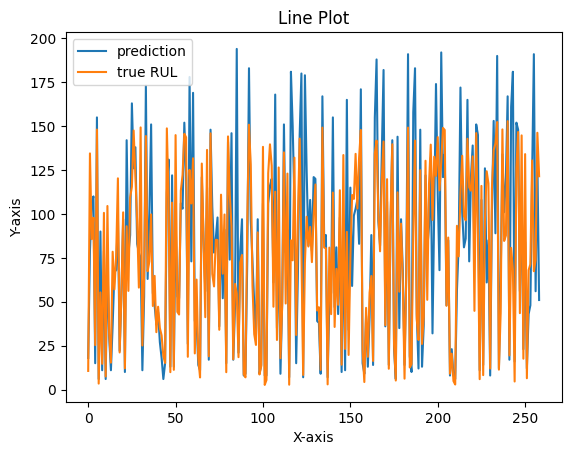

In [ ]:


def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
plot_series(true_rul, preds_for_last_example)

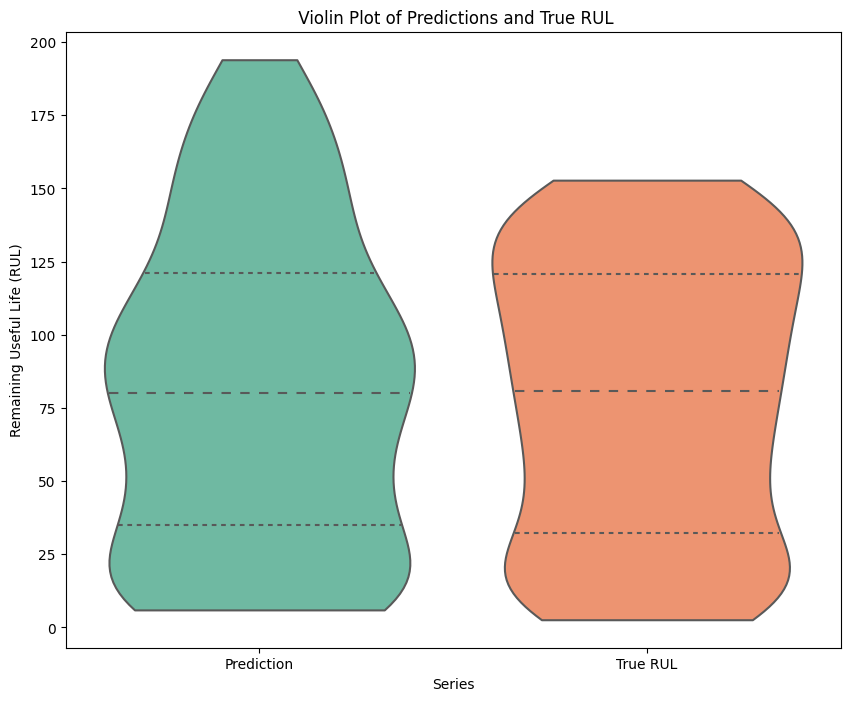

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                   cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8, trim=True,
                   range=(min_value, max_value))

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series(true_rul, preds_for_last_example)


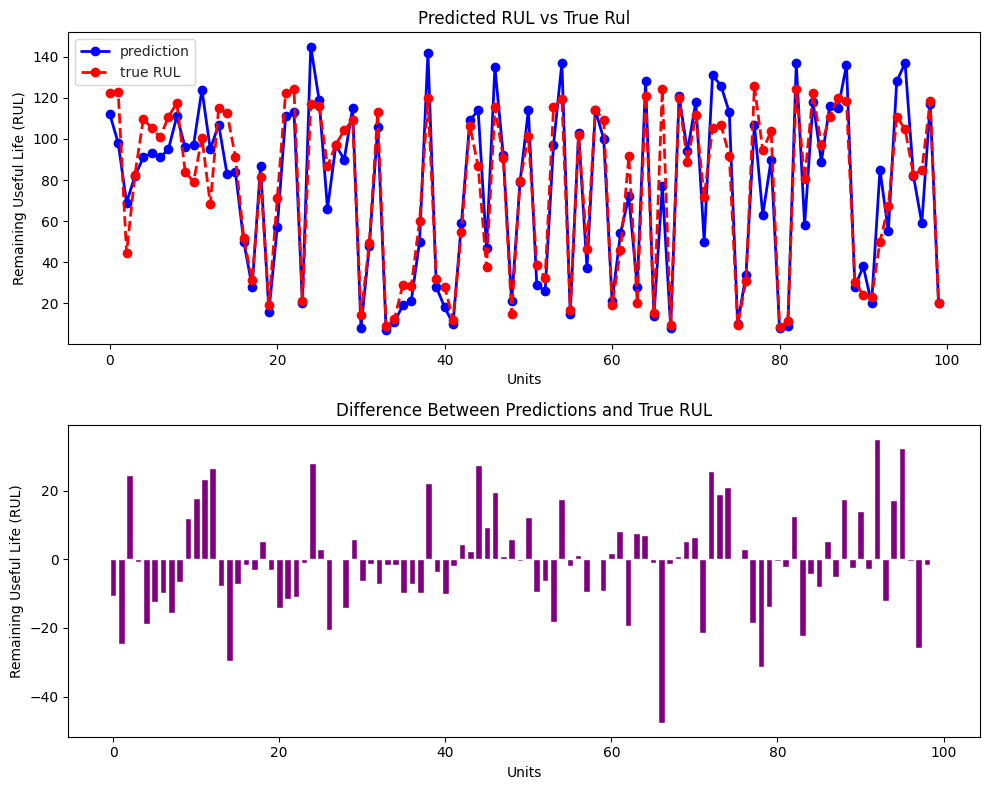

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series(true_rul, preds_for_last_example)


In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_critical_mae(predictions, true_rul):
    # Convert lists to numpy arrays for element-wise operations
    predictions = np.array(predictions)
    true_rul = np.array(true_rul)

    # Find the indices where true RUL is less than 15
    critical_indices = np.where(true_rul < 15)

    # Extract the critical predictions and true RUL
    critical_predictions = predictions[critical_indices]
    critical_true_rul = true_rul[critical_indices]

    # Calculate the MAE
    mae = mean_absolute_error(critical_true_rul, critical_predictions)

    return mae


In [ ]:
mae = evaluate_critical_mae(preds_for_last_example, true_rul)
print(f"The MAE for critical predictions is: {mae}")


The MAE for critical predictions is: 4.02860562394305


##clipping the ture rul

In [ ]:
# Assuming 'true_rul' is a numpy array
true_rul = np.clip(true_rul, a_min=None, a_max=150)


### Computing RMSE and MAE using last 5 examples

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
# rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

MAE = (mean_absolute_error(true_rul, mean_pred_for_each_engine))
print("MAE", MAE)

MAE_perc= mean_absolute_percentage_error(true_rul,mean_pred_for_each_engine)
print("MAE   " , MAE_perc)


s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

RMSE:  25.969482183253387
MAE 18.094825164875928
MAE    0.3145206386108706
S-score:  12846.982989204538


### Computing RMSE and MAE using only the last example

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)
MAE_new = mean_absolute_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " ,MAE_new)

MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " , MAE_perc)
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

RMSE (Taking only last examples):  25.820265111799944
% MAE only last examples   17.886208949402032
% MAE only last examples   0.29021528456382106
S-score:  10833.431179482766


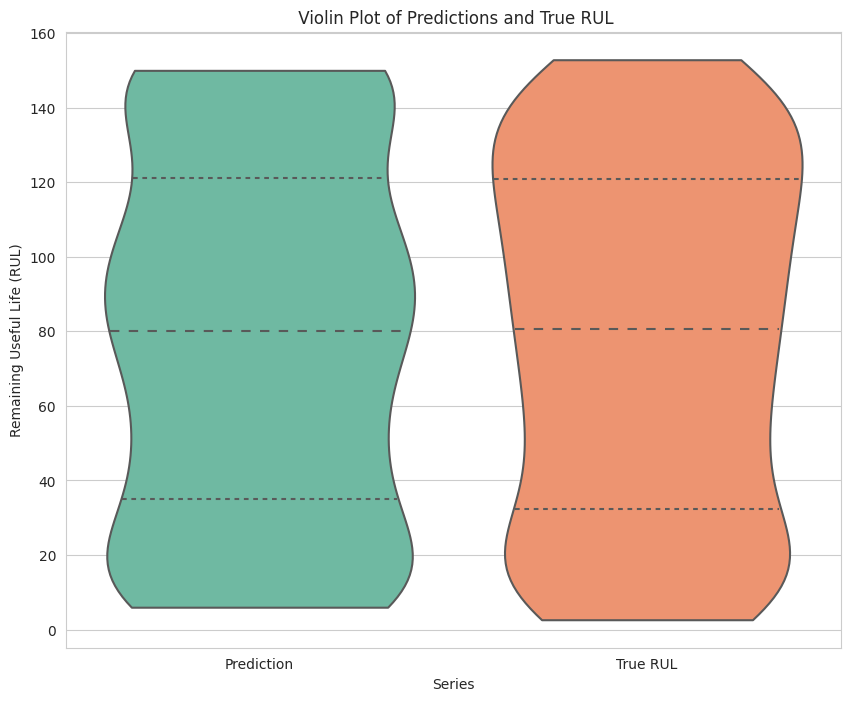

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                   cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8, trim=True,
                   range=(min_value, max_value))

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series(true_rul, preds_for_last_example)


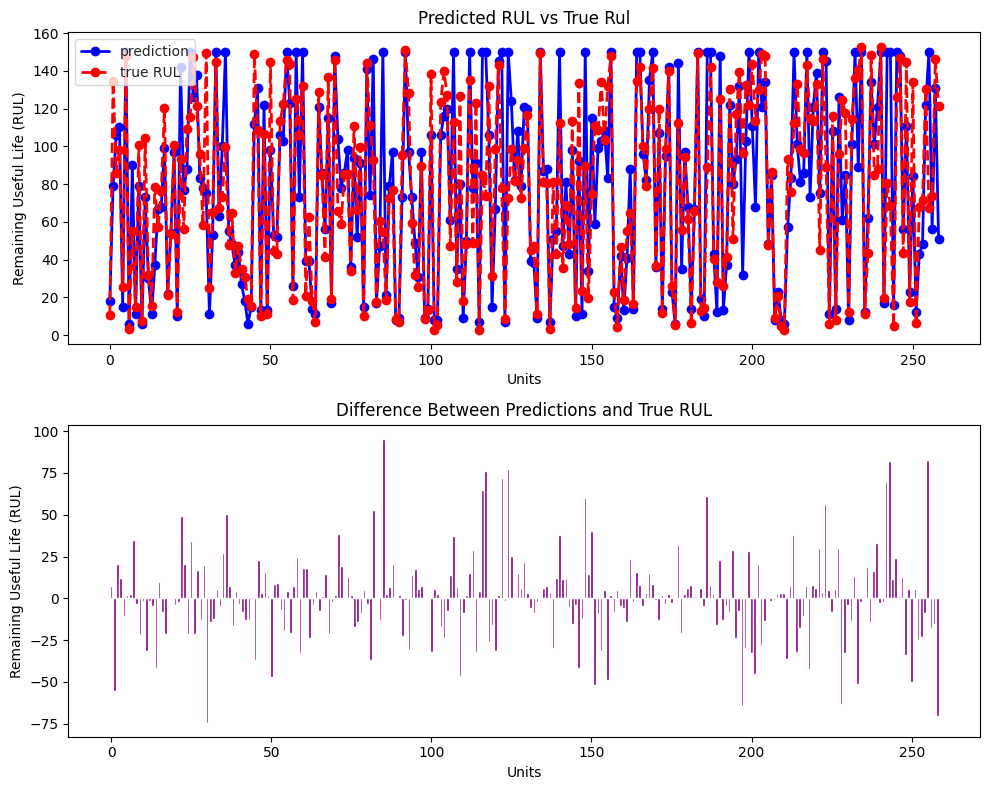

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series(true_rul, preds_for_last_example)


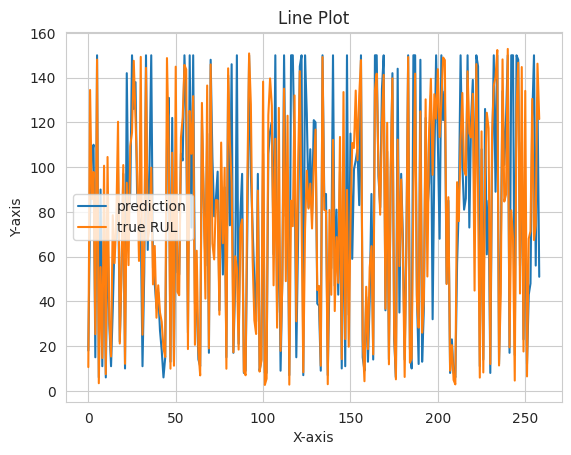

In [ ]:


def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
plot_series(true_rul, preds_for_last_example)

# RUL prediction using Long Short Term Memory (LSTM) FD003

In this notebook, we will use LSTM to predict RUL of NASA's turbofan engine dataset FD002. We will show the implementation without going into the theory of LSTM.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(3321)

In [ ]:
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

## Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 125
* Window length: 30
* Shift: 1
* Data scaling: Standard scaling and full dataset scaling.

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate.

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly.

In [ ]:
import os
import pandas as pd

# Prompt the user for the flight condition
flight_condition = input("Please enter the flight condition (1-4): ")

# Validate the user input
while flight_condition not in ['1', '2', '3', '4']:
    print("Invalid input. Please try again.")
    flight_condition = input("Please enter the flight condition (1-4): ")

# Set the file names based on the flight condition
train_file = f'train_FD00{flight_condition}.txt'
test_file = f'test_FD00{flight_condition}.txt'
rul_file = f'RUL_FD00{flight_condition}.txt'

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('/content/dataset/CMaps', train_file)
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('/content/dataset/CMaps', test_file)
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the RUL dataset as a dataframe
rul_dataset_path = os.path.join('/content/dataset/CMaps', rul_file)
true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



Please enter the flight condition (1-4): 3


In [ ]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function return last examples and number of last examples (a scaler) as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows

In [ ]:

window_length = 30
shift = 1
early_rul = 125
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped = [0,1,2,3,4,5,9,14,20,22,23]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

<ipython-input-112-1715ad1c7bf6>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-112-1715ad1c7bf6>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional

Processed trianing data shape:  (21820, 30, 15)
Processed training ruls shape:  (21820,)
Processed test data shape:  (500, 30, 15)
True RUL shape:  (100,)


<ipython-input-112-1715ad1c7bf6>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-113-dc420933ba69>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional

In [ ]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 48)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (17456, 30, 15)
Processed validation data shape:  (4364, 30, 15)
Processed train targets shape:  (17456,)
Processed validation targets shape:  (4364,)


In [ ]:
def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape = (window_length, processed_train_data.shape[2]), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences=True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [ ]:
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),
                    batch_size = 128, verbose = 2)

Epoch 1/10
137/137 - 7s - loss: 3288.3474 - val_loss: 347.1630 - 7s/epoch - 54ms/step
Epoch 2/10
137/137 - 1s - loss: 243.5596 - val_loss: 207.5224 - 1s/epoch - 9ms/step
Epoch 3/10
137/137 - 1s - loss: 165.0374 - val_loss: 158.1778 - 1s/epoch - 9ms/step
Epoch 4/10
137/137 - 1s - loss: 132.7133 - val_loss: 121.6735 - 1s/epoch - 8ms/step
Epoch 5/10
137/137 - 1s - loss: 119.8212 - val_loss: 110.7693 - 1s/epoch - 8ms/step
Epoch 6/10
137/137 - 1s - loss: 111.1654 - val_loss: 104.0727 - 1s/epoch - 8ms/step
Epoch 7/10
137/137 - 1s - loss: 98.2187 - val_loss: 103.6659 - 1s/epoch - 8ms/step
Epoch 8/10
137/137 - 1s - loss: 96.9908 - val_loss: 100.1422 - 1s/epoch - 8ms/step
Epoch 9/10
137/137 - 1s - loss: 90.1288 - val_loss: 83.6263 - 1s/epoch - 8ms/step
Epoch 10/10
137/137 - 1s - loss: 83.9663 - val_loss: 86.6994 - 1s/epoch - 8ms/step


# Results FD003

In [ ]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

16/16 [==============================] - 1s 3ms/step
RMSE:  15.141513175312488


We will now compute the RMSE by taking only last example of each engine.

### Computing RMSE and MAE using last 5 examples

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
# rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

MAE = (mean_absolute_error(true_rul, mean_pred_for_each_engine))
print("MAE", MAE)

MAE_perc= mean_absolute_percentage_error(true_rul,mean_pred_for_each_engine)
print("MAE   " , MAE_perc)


s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

RMSE:  15.141513175312488
MAE 11.587211685180664
MAE    0.2114921732809048
S-score:  375.1661445415284


### Computing RMSE and MAE using last  example

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)
MAE_new = mean_absolute_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " ,MAE_new)

MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " , MAE_perc)
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

RMSE (Taking only last examples):  13.79427836806829
% MAE only last examples   10.74395896434784
% MAE only last examples   0.1779147971993347
S-score:  257.0967840795584


If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where,

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

It is very likely that readers may get sligtly different results while running this notebook on their system. This happens because of the nondeterministic nature of some deep learning operations and dependence of libraries like `Tensorflow` on computer architecture. Therefore, to make our results reproducible, we also share saved models of all our notebooks. All saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/tree/master/saved_models/cmapss). A notebook describing the procedure to use the saved models can be found [here](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_using_saved_model_deep_learning.ipynb). As a final note remember that hyperparameter tuning is more of an art than science. It is possible to obtain better results than what has been obtained here by choosing better set of hyperparameters.

For other reproducible results on RUL, interested readers can visit my [project page](https://biswajitsahoo1111.github.io/rul_codes_open).

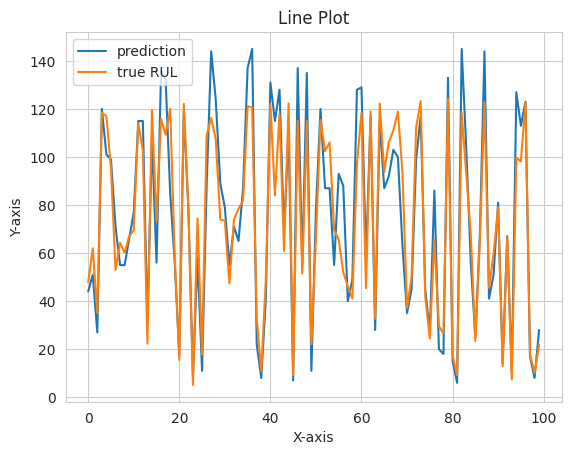

In [ ]:


def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
plot_series(true_rul, preds_for_last_example)

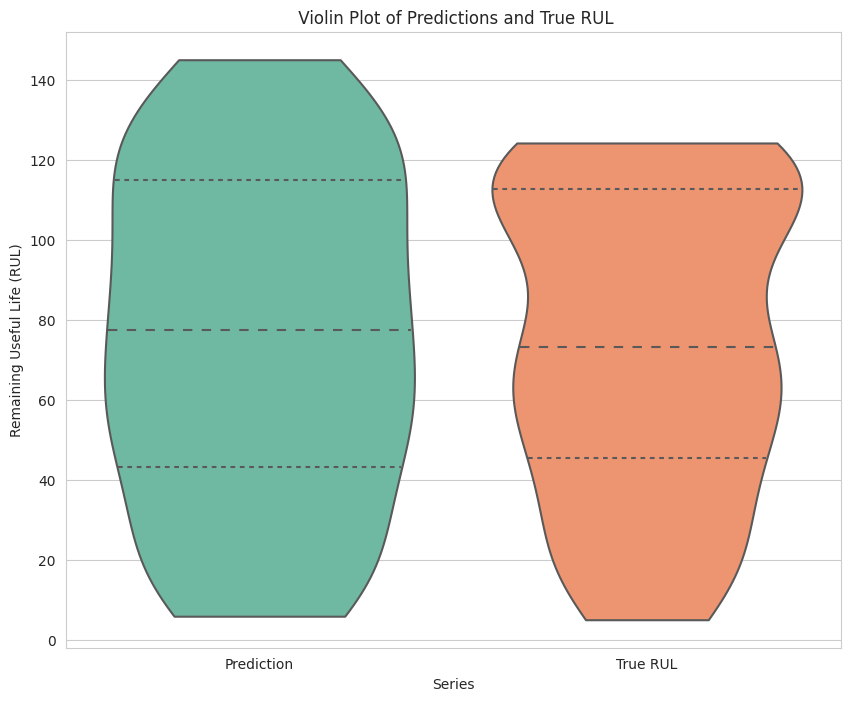

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                   cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8, trim=True,
                   range=(min_value, max_value))

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series(true_rul, preds_for_last_example)


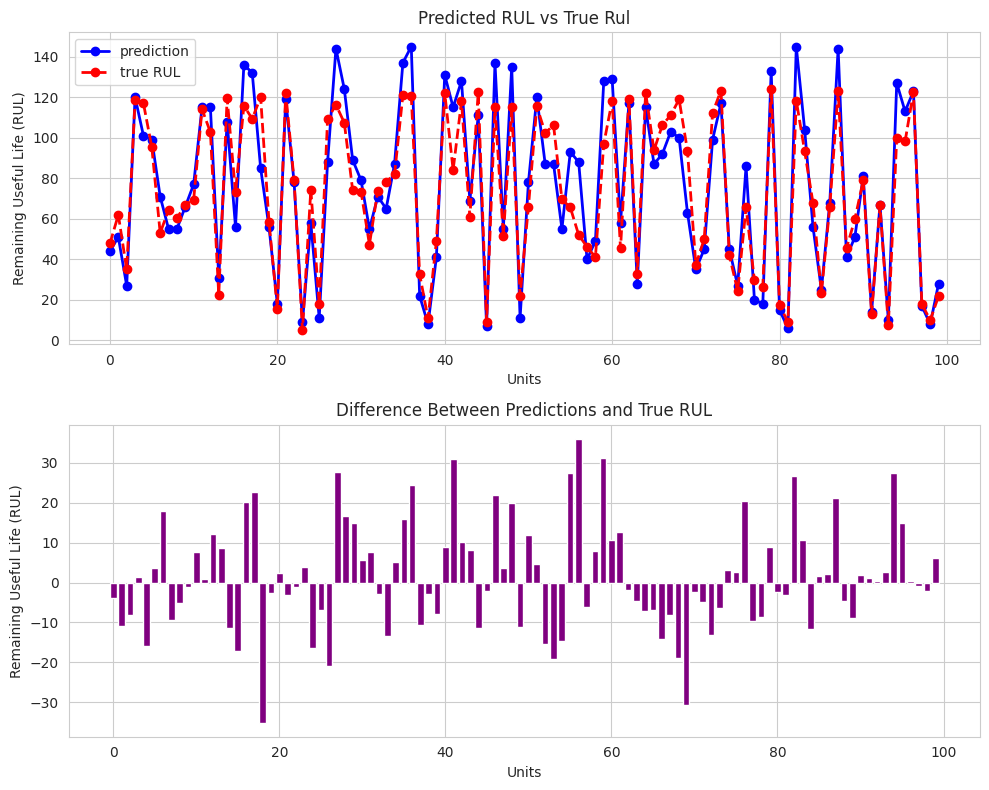

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series(true_rul, preds_for_last_example)


In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_critical_mae(predictions, true_rul):
    # Convert lists to numpy arrays for element-wise operations
    predictions = np.array(predictions)
    true_rul = np.array(true_rul)

    # Find the indices where true RUL is less than 15
    critical_indices = np.where(true_rul < 15)

    # Extract the critical predictions and true RUL
    critical_predictions = predictions[critical_indices]
    critical_true_rul = true_rul[critical_indices]

    # Calculate the MAE
    mae = mean_absolute_error(critical_true_rul, critical_predictions)

    return mae


In [ ]:
mae = evaluate_critical_mae(preds_for_last_example, true_rul)
print(f"The MAE for critical predictions is: {mae}")


The MAE for critical predictions is: 3.9500357839796276


# RUL prediction using Long Short Term Memory (LSTM) FD004

In this notebook, we will use LSTM to predict RUL of NASA's turbofan engine dataset FD004. We will show the implementation without going into the theory of LSTM.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import pandas as pd
from pathlib import Path
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

np.random.seed(2627)

In [ ]:
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.6.0
Numpy version:  1.19.5
Pandas version:  1.3.3
Scikit-learn version:  1.0


## Data Preprocessing

We strongly encourage readers to go through the [dataset description and prreprocessing notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb). In that notebook we have explained how data preprocessing functions work with simple examples. In this notebook we will only use those functions. So prior familiarity with these functions is an advantage. Below are the parameters that we will use for data preprocessing:

* Degradation model: Piecewise linear
* Early RUL: 125
* Window length: 30
* Shift: 1
* Data scaling: No (Tree based methods don't require data scaling)

We will calculate two prediction scores on test data. In one case, we will take last 5 examples of test data for engine, calculate their predictions, and finally average those for each engine. In the second case, we will take only the last example of each engine and make predictions. The logic behind taking last 5 examples and averaging their predictions is to make the prediction robust against outliers. Due to some external factor, if our last example happens to be corrupted, its prediction outcome might be far off from the actual one. But if we average predictions from last 5 examples, we will get a more conservative estimate.

In the following cell we will show boxplots of each column of training data. That will give us an idea about the values in different columns. If all the values in a column are constant, we drop those columns from our analysis.

Readers can download the data from [here](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan). In the following cells, wherever data are read from a folder, readers should change the string to point to the respective folder from their system to run this notebook seamlessly.

In [ ]:
import os
import pandas as pd

# Prompt the user for the flight condition
flight_condition = input("Please enter the flight condition (1-4): ")

# Validate the user input
while flight_condition not in ['1', '2', '3', '4']:
    print("Invalid input. Please try again.")
    flight_condition = input("Please enter the flight condition (1-4): ")

# Set the file names based on the flight condition
train_file = f'train_FD00{flight_condition}.txt'
test_file = f'test_FD00{flight_condition}.txt'
rul_file = f'RUL_FD00{flight_condition}.txt'

# Load the train dataset as a dataframe
train_dataset_path = os.path.join('/content/dataset/CMaps', train_file)
train_data = pd.read_csv(train_dataset_path, delimiter='\s+', header=None)

# Load the test dataset as a dataframe
test_dataset_path = os.path.join('/content/dataset/CMaps', test_file)
test_data = pd.read_csv(test_dataset_path, delimiter='\s+', header=None)

# Load the RUL dataset as a dataframe
rul_dataset_path = os.path.join('/content/dataset/CMaps', rul_file)
true_rul = pd.read_csv(rul_dataset_path, delimiter='\s+', header=None)



Please enter the flight condition (1-4): 4


In [ ]:
def process_targets(data_length, early_rul = None):
    """
    Takes datalength and earlyrul as input and
    creates target rul.
    """
    if early_rul == None:
        return np.arange(data_length-1, -1, -1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <= 0:
            return np.arange(data_length-1, -1, -1)
        else:
            return np.append(early_rul*np.ones(shape = (early_rul_duration,)), np.arange(early_rul-1, -1, -1))

In [ ]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets
    from input_data and target_data.

    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1

    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is
    produced as output.**

    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of
               29 data points between two consecutive batches.

    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)

    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data

    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

We will modify the next functions a little bit to handle a special case. Later, for this dataset, we will be using window_size of 30. But upon some investigation, it can be found that there are a few test engines for which test data doesn't contain 30 rows. If test data for an engine doesn't contain 30 rows, how can we extract 30 rows from it? To circumvent this issue, we will append zeros to the end of that dataset. But while making predictions, we will ignore those appended zeros. This is called masking. The appended extra zeros are masked so that it doesn't influence our prediction. In Tensorflow, LSTM layers can take a mask argument to ignore specific input values. So we modify the function below to create a mask that is compatible with Tensorflow.

Similarly, to the decoder we pass only the last line of every window of test dataset. But if we have appended last few lines of data of an engine by zeros, taking its last row would mean taking all zeros. To overcome this problem, the function returns test_decoder_for_an_engine as another output.

In [ ]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins.

    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.

    The function returns last examples, number of last examples (a scaler), a mask, and test_decoder sequence as output.
    We need the second output later. If we are extracting more than 1 last examples, we have to
    average their prediction results. The second scaler halps us do just that.
    """
    if len(test_data_for_an_engine) < window_length:
        mask_length = window_length - len(test_data_for_an_engine)
        batched_test_data_for_an_engine = np.concatenate((test_data_for_an_engine,
                                                          np.zeros((mask_length, test_data_for_an_engine.shape[1]))))
        mask = np.concatenate((np.repeat([True], len(test_data_for_an_engine)), np.repeat([False], mask_length)))
        num_test_windows = 1    # This has to be 1 as number of data points is less than window length
        return batched_test_data_for_an_engine[np.newaxis, :], num_test_windows, mask[np.newaxis, :]

    else:
        max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1

        if max_num_test_batches < num_test_windows:
            required_len = (max_num_test_batches -1)* shift + window_length
            batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, max_num_test_batches, mask

        else:
            required_len = (num_test_windows - 1) * shift + window_length
            batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                              target_data = None,
                                                                              window_length = window_length, shift = shift)
            m, n = batched_test_data_for_an_engine.shape[0], batched_test_data_for_an_engine.shape[1]
            mask = np.repeat([True], m * n).reshape(m, n)
            return batched_test_data_for_an_engine, num_test_windows, mask

There are two scaling strategies that we can employ. We can scale columnwise, ignoring individual engine based scaling. Or we can scale enginewise.

In [ ]:

window_length = 30
shift = 1
early_rul = 150
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for
# each engine is taken. If set to a different number, that many windows from last are taken.
# Final output is the average output of all windows.
num_test_windows = 5
processed_test_data = []
num_test_windows_list = []
test_mask = []

columns_to_be_dropped = [0,1,2,3,4]

train_data_first_column = train_data[0]
test_data_first_column = test_data[0]

# Scale data for all engines
# scaler = MinMaxScaler(feature_range = (-1, 1))
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process trianing data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values

    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")

    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets,
                                                                                window_length = window_length, shift = shift)

    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values


    # Prepare test data
    test_data_for_an_engine, num_windows, test_mask_for_an_engine = process_test_data(temp_test_data,
                                                                                      window_length = window_length,
                                                                                      shift = shift,
                                                                                      num_test_windows = num_test_windows)

    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)
    test_mask.append(test_mask_for_an_engine)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values
test_mask = np.concatenate(test_mask)

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("Test mask shape: ", test_mask.shape)
print("True RUL shape: ", true_rul.shape)

<ipython-input-87-c49a18048e5a>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
<ipython-input-87-c49a18048e5a>:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

Processed trianing data shape:  (54028, 30, 21)
Processed training ruls shape:  (54028,)
Processed test data shape:  (1196, 30, 21)
Test mask shape:  (1196, 30)
True RUL shape:  (248,)


Targets vary from 0 to 192 (for example) for the engine that has a service life of 193 cycles. But in deep learning it's usually a good idea to keep numbers within a range. Below we scale targets to a range of 0 to 1.

In [ ]:
target_scaler = MinMaxScaler(feature_range = (0, 1))
processed_train_targets = target_scaler.fit_transform(processed_train_targets.reshape(-1, 1)).reshape(-1)

## Training and validation split
We will take 20% of training data (sampled randomly) as our validation set. We will monitor the training of our model using the validation set.

In [ ]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (43222, 30, 21)
Processed validation data shape:  (10806, 30, 21)
Processed train targets shape:  (43222,)
Processed validation targets shape:  (10806,)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((processed_train_data, processed_train_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((processed_val_data, processed_val_targets)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((processed_test_data, test_mask)).batch(128).prefetch(tf.data.AUTOTUNE)

In [ ]:
## Create a custom model
class CreateModel(tf.keras.Model):
    def __init__(self, input_shape, **kwargs):
        super().__init__(**kwargs)
        self.lstm_layer_1 = layers.LSTM(128, input_shape = input_shape, return_sequences = True, activation = "tanh")
        self.lstm_layer_2 = layers.LSTM(64, activation = "tanh", return_sequences= True)
        self.lstm_layer_3 = layers.LSTM(32, activation = "tanh")
        self.dense_1 = layers.Dense(64, activation = "relu")
        self.dense_2 = layers.Dense(96, activation = "relu")
        self.dense_3 = layers.Dense(1)


    def call(self, input_data, mask = None, **kwargs):
        x = self.lstm_layer_1(input_data, mask = mask)
        x = self.lstm_layer_2(x)
        x = self.lstm_layer_3(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.dense_3(x)

Instantiate model.

In [ ]:
input_shape = (window_length, processed_train_data.shape[2])
model = CreateModel(input_shape = input_shape)

### Training
As we have written a custom model, we can write a manual training loop for training.

In [ ]:
def train_model(net, train_data_iter, validation_data_iter, lr, num_epochs):
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    loss_object = tf.keras.losses.MeanSquaredError()

    train_metric = tf.keras.metrics.MeanSquaredError()
    val_metric = tf.keras.metrics.MeanSquaredError()

    for epoch in range(num_epochs):
        for X, Y in train_data_iter:
            with tf.GradientTape() as tape:
                output = net(X, mask = None)
                l = loss_object(Y, output)
            gradients = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(gradients, net.trainable_variables))
            # Update metric
            train_metric.update_state(Y, output)

        # Validation loop
        for val_X, val_Y in validation_data_iter:
            val_output = net(val_X, mask = None)
            # Update validation metric
            val_metric.update_state(val_Y, val_output)

        train_mse = train_metric.result()
        val_mse = val_metric.result()

        print(f'epoch: {epoch + 1}, Training loss: {train_mse}, Validation loss: {val_mse}')

        # Reset metric states
        train_metric.reset_states()
        val_metric.reset_states()

In [ ]:
history=train_model(net = model, train_data_iter = train_dataset, validation_data_iter= val_dataset, lr = 0.001, num_epochs = 10)

epoch: 1, Training loss: 0.052042752504348755, Validation loss: 0.033466484397649765
epoch: 2, Training loss: 0.029896412044763565, Validation loss: 0.028341859579086304
epoch: 3, Training loss: 0.027137242257595062, Validation loss: 0.025333749130368233
epoch: 4, Training loss: 0.025502195581793785, Validation loss: 0.02451353892683983
epoch: 5, Training loss: 0.023958304896950722, Validation loss: 0.023624060675501823
epoch: 6, Training loss: 0.022849194705486298, Validation loss: 0.024114837870001793
epoch: 7, Training loss: 0.021113591268658638, Validation loss: 0.022487493231892586
epoch: 8, Training loss: 0.019882069900631905, Validation loss: 0.021631887182593346
epoch: 9, Training loss: 0.01882973127067089, Validation loss: 0.021342722699046135
epoch: 10, Training loss: 0.017421577125787735, Validation loss: 0.01836289092898369


# Result FD004

### Making prediction

In [ ]:
rul_pred_scaled = []
for test_data, test_mask in test_dataset:
    batch_pred = model(test_data, mask = test_mask)
    rul_pred_scaled.extend(batch_pred.numpy().reshape(-1))

rul_pred_scaled = np.array(rul_pred_scaled) # initially rul_pred_scaled was just a list. So converted it to numpy array.
rul_pred = target_scaler.inverse_transform(rul_pred_scaled.reshape(-1, 1)).reshape(-1)

### Computing RMSE and MAE using last 5 examples

In [ ]:
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows))
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
MAE = mean_absolute_error(true_rul, mean_pred_for_each_engine)
print("RMSE: ", RMSE)
print("MAE: ", MAE)

MAE_perc= mean_absolute_percentage_error(true_rul,mean_pred_for_each_engine)
print("MAE   " , MAE_perc)


s_score = compute_s_score(true_rul, mean_pred_for_each_engine)
print("S-score: ", s_score)

RMSE:  29.38823677700239
MAE:  22.941654827902394
MAE    0.43580475811149433
S-score:  12748.783293038632


## Computing RMSE and MAE using only the last example

In [ ]:
indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
MAE_new = mean_absolute_error(true_rul, preds_for_last_example)
print("RMSE (Taking only last examples): ", RMSE_new)
print("MAE (Taking only last example): ", MAE_new)

MAE_perc= mean_absolute_percentage_error(true_rul,preds_for_last_example)
print("% MAE only last examples  " , MAE_perc)
s_score = compute_s_score(true_rul, preds_for_last_example)
print("S-score: ", s_score)

RMSE (Taking only last examples):  29.435246281099328
MAE (Taking only last example):  22.830334198090338
% MAE only last examples   0.39199495157984415
S-score:  12513.92265158481


If you are not convinced by above calculations, take a look at the last section of [this notebook](https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_FD001_xgboost_piecewise_linear_degradation_model.ipynb).

For CMAPSS data, along with RMSE another metric (S-score) is usually reported in literature. S-score is defined as:

$$S= \sum_{i=1}^N{s_i}$$

where,

$$
\begin{equation}
    s_i=
    \begin{cases}
      (e^{-\frac{d_i}{13}})-1, & \text{for}\ d_i < 1 \\
      (e^{\frac{d_i}{10}})-1, & \text{for}\ d_i \geq 1\\
    \end{cases}
  \end{equation}
  $$
  
We can compute the S-metric as follows.

### Save the model weights

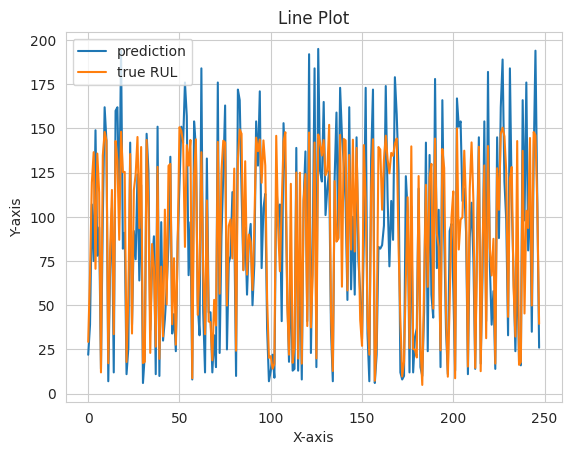

In [ ]:


def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot series1 as a line plot
    ax.plot(series1_list, label='prediction')

    # Plot series2 as a line plot
    ax.plot(series2_list, label='true RUL')

    # Add labels and title
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Line Plot')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()
plot_series(true_rul, preds_for_last_example)

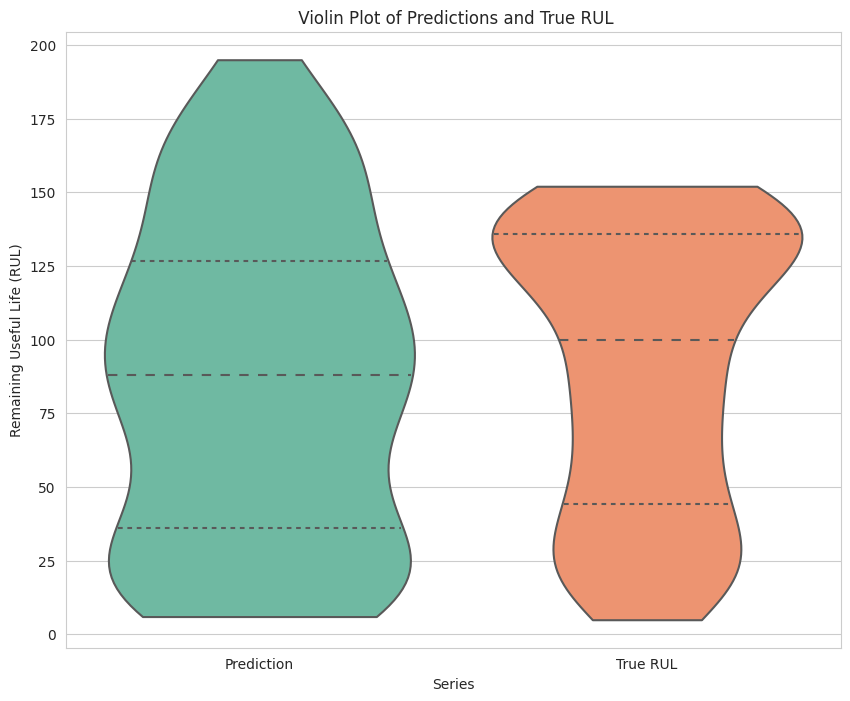

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    plt.figure(figsize=(10, 8))

    # Create dataframes for each series
    df1 = pd.DataFrame(series1_list, columns=['value'])
    df1['type'] = 'Prediction'
    df2 = pd.DataFrame(series2_list, columns=['value'])
    df2['type'] = 'True RUL'

    # Concatenate the dataframes
    df = pd.concat([df1, df2])

    # Calculate the range of real values in the series
    min_value = min(min(series1_list), min(series2_list))
    max_value = max(max(series1_list), max(series2_list))

    # Create a violin plot with split, specifying the range of values
    sns.violinplot(x='type', y='value', data=df, split=True, inner='quartile', palette="Set2",
                   cut=0, scale='width', bw='silverman', width=0.8, saturation=0.8, trim=True,
                   range=(min_value, max_value))

    # Create labels
    plt.xlabel('Series')
    plt.ylabel('Remaining Useful Life (RUL)')
    plt.title(' Violin Plot of Predictions and True RUL')

    # Show the plot
    plt.show()


# Call the function
plot_series(true_rul, preds_for_last_example)


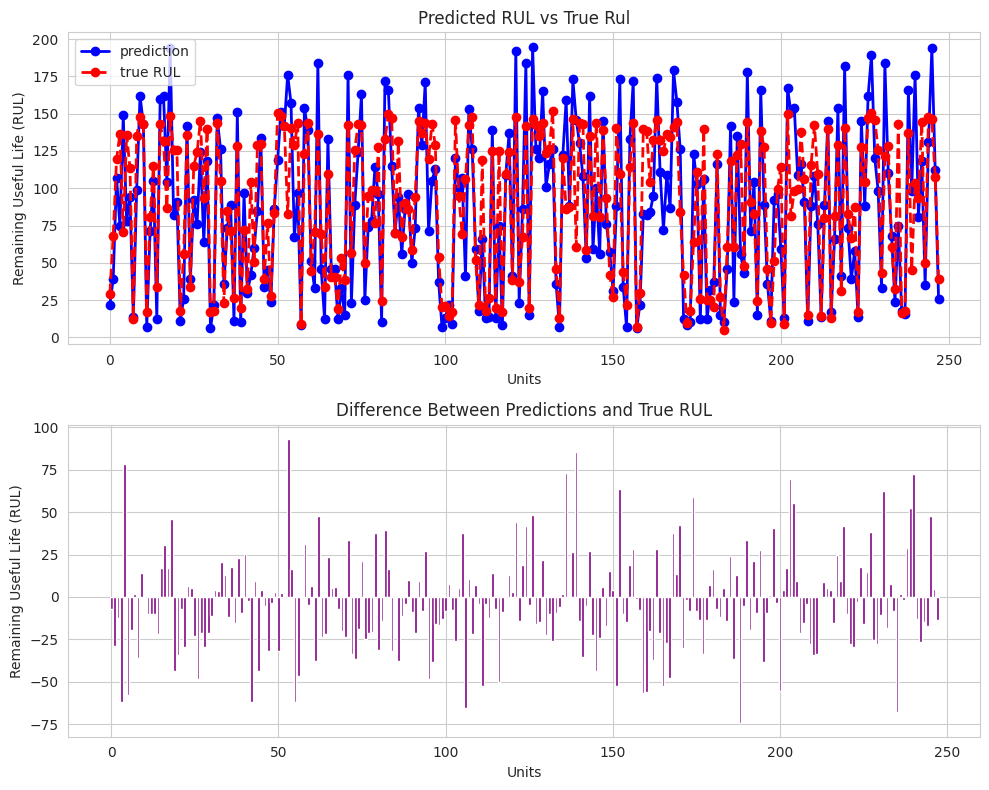

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_series(series1, series2):
    # Convert series to lists
    series1_list = series1.tolist()
    series2_list = series2.tolist()

    # Create a figure and axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Use seaborn styles
    sns.set_style("whitegrid")

    # Plot series1 as a line plot
    ax1.plot(series1_list, label='prediction', marker='o', linestyle='-', color='b')

    # Plot series2 as a line plot
    ax1.plot(series2_list, label='true RUL', marker='o', linestyle='--', color='r')

    # Add labels and title
    ax1.set_xlabel('Units')
    ax1.set_ylabel('Remaining Useful Life (RUL)')
    ax1.set_title('Predicted RUL vs True Rul')

    # Increase the line width
    for line in ax1.lines:
        line.set_linewidth(2)

    # Add legend
    ax1.legend()

    # Calculate difference between series1 and series2
    diff = np.array(series1_list) - np.array(series2_list)

    # Create a bar plot for differences
    ax2.bar(range(len(diff)), diff, color='purple')

    # Add labels and title
    ax2.set_xlabel('Units')
    ax2.set_ylabel('Remaining Useful Life (RUL)')
    ax2.set_title('Difference Between Predictions and True RUL')

    # Adjust space between the plots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Call the function
plot_series(true_rul, preds_for_last_example)


In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_critical_mae(predictions, true_rul):
    # Convert lists to numpy arrays for element-wise operations
    predictions = np.array(predictions)
    true_rul = np.array(true_rul)

    # Find the indices where true RUL is less than 15
    critical_indices = np.where(true_rul < 15)

    # Extract the critical predictions and true RUL
    critical_predictions = predictions[critical_indices]
    critical_true_rul = true_rul[critical_indices]

    # Calculate the MAE
    mae = mean_absolute_error(critical_true_rul, critical_predictions)

    return mae


In [ ]:
mae = evaluate_critical_mae(preds_for_last_example, true_rul)
print(f"The MAE for critical predictions is: {mae}")
c

The MAE for critical predictions is: 9.075825423002243


# FD001

last 5

| Metric | Value                 |
|--------|-----------------------|
| RMSE   | 14.924283414675442    |
| MAE    | 11.69177043247223     |
| MAE    | 0.2015629544201476    |
| S-score| 433.61579520912676    |


last example

| Metric                            | Value                 |
|-----------------------------------|-----------------------|
| RMSE (Taking only last examples)  | 15.109726898982043    |
| % MAE only last examples          | 11.239905338287354    |
| % MAE only last examples          | 0.1641893299713881    |
| S-score                           | 420.54334755535365    |


| Metric                            | Last 5 Example           | Last  Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 14.924283414675442    | 15.109726898982043     |
| MAE                               | 11.69177043247223     | 11.239905338287354     |
| MAE                               | 0.2015629544201476    | 0.1641893299713881     |
| S-score                           | 433.61579520912676    | 420.54334755535365     |


# FD002

last 5

| Metric | Value                 |
|--------|-----------------------|
| RMSE   | 25.969482183253387    |
| MAE    | 18.094825164875928    |
| MAE    | 0.3145206386108706    |
| S-score| 12846.982989204538    |


last examples

| Metric                            | Value                 |
|-----------------------------------|-----------------------|
| RMSE  | 25.820265111799944    |
| MAE           | 17.886208949402032    |
| % MAE          | 0.29021528456382106   |
| S-score                           | 10833.431179482766    |


| Metric                            | Last 5           | Last Examples        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 25.969482183253387    | 25.820265111799944     |
| MAE                               | 18.094825164875928    | 17.886208949402032     |
| MAE                               | 0.3145206386108706    | 0.29021528456382106    |
| S-score                           | 12846.982989204538    | 10833.431179482766    |


# fd003

last 5

| Metric                            | Value                 |
|-----------------------------------|-----------------------|
| RMSE (Taking only last examples)  | 13.79427836806829     |
| MAE only last examples          | 10.74395896434784     |
| % MAE only last examples          | 0.1779147971993347    |
| S-score                           | 257.0967840795584     |


last

| Metric | Value                 |
|--------|-----------------------|
| RMSE   | 15.141513175312488    |
| MAE    | 11.587211685180664    |
| MAE    | 0.2114921732809048   |
| S-score| 375.1661445415284    |


| Metric                            | Last 5 Example           | Last  Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE  | 13.79427836806829     | 15.141513175312488     |
| MAE          | 10.74395896434784     | 11.587211685180664     |
| % MAE           | 0.1779147971993347    | 0.2114921732809048     |
| S-score                           | 257.0967840795584     | 375.1661445415284     |


#fd004

last 5

| Metric | Value                 |
|--------|-----------------------|
| RMSE   | 29.38823677700239     |
| MAE    | 22.941654827902394    |
| MAE    | 0.43580475811149433   |
| S-score| 12748.783293038632    |


last

| Metric                            | Value                 |
|-----------------------------------|-----------------------|
| RMSE (Taking only last examples)  | 29.435246281099328    |
| MAE (Taking only last example)    | 22.830334198090338    |
| % MAE only last examples          | 0.39199495157984415   |
| S-score                           | 12513.92265158481     |


| Metric                            | Last 5 Example           | Last  Examples        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 29.38823677700239     | 29.435246281099328     |
| MAE                               | 22.941654827902394    | 22.830334198090338     |
| MAE                               | 0.43580475811149433   | 0.39199495157984415    |
| S-score                           | 12748.783293038632    | 12513.92265158481     |


# Complete metrics

## FD001

| Metric                            | Last 5 Example           | Last Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 14.924283414675442    | 15.109726898982043     |
| MAE                               | 11.69177043247223     | 11.239905338287354     |
| MAE                               | 0.2015629544201476    | 0.1641893299713881     |
| S-score                           | 433.61579520912676    | 420.54334755535365     |

## FD002

| Metric                            | Last 5           | Last Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 25.969482183253387    | 25.820265111799944     |
| MAE                               | 18.094825164875928    | 17.886208949402032     |
| MAE                               | 0.3145206386108706    | 0.29021528456382106    |
| S-score                           | 12846.982989204538    | 10833.431179482766    |

## FD003

| Metric                            | Last 5 Example           | Last Example        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 13.79427836806829     | 15.141513175312488     |
| MAE                               | 10.74395896434784     | 11.587211685180664     |
| % MAE                             | 0.1779147971993347    | 0.2114921732809048     |
| S-score                           | 257.0967840795584     | 375.1661445415284     |

## FD004

| Metric                            | Last 5 Example           | Last Examples        |
|-----------------------------------|-----------------------|------------------------|
| RMSE                              | 29.38823677700239     | 29.435246281099328     |
| MAE                               | 22.941654827902394    | 22.830334198090338     |
| MAE                               | 0.43580475811149433   | 0.39199495157984415    |
| S-score                           | 12748.783293038632    | 12513.92265158481     |


# Critical errors

| FD Group | MAE for Critical Predictions |
|----------|-----------------------------|
| FD001    | 1.119092305501302           |
| FD002    | 4.02860562394305            |
| FD003    | 3.9500357839796276          |
| FD004    | 9.075825423002243           |
